# Thêm các thư viện

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import re
import nltk
import string
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Mô tả bài toán
* **Mục tiêu:** Phân loại các câu hỏi trên Quora là toxic hay non-toxic
* **Input:** Câu hỏi tiếng anh được cho dưới dạng text
* **Output:** 0/1 (non-toxic/toxic)

# Phân tích dữ liệu
# 1. Lấy dữ liệu của Quora

In [ ]:
train_data = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_data = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

# 2. Tập train
Dữ liệu gồm 3 giá trị: qid, question_text, target
* qid: unique id của câu hỏi
* question_text: câu hỏi cần phân loại được cho dưới dạng text
* target: label 0/1 của câu hỏi (non-toxic/toxic)


Khi phân loại, ta dùng question_text là đầu vào X, target là label y

In [ ]:
train_data

Kiểm tra tập train

In [ ]:
train_data.info()

In [ ]:
# Lấy ra câu có nhãn 0
non_toxic_data = train_data[train_data.target == 0]
# Lấy ra câu có nhãn 1
toxic_data = train_data[train_data.target == 1]

Quan sát một số câu hỏi có nhãn 0 (non-toxic)

In [ ]:
# Lấy mẫu 5 câu hỏi nhãn 0
for sentence in non_toxic_data.question_text.sample(5):
    print(sentence)

Quan sát một số câu hỏi có nhãn 1 (toxic)

In [ ]:
# Lấy mẫu 5 câu hỏi nhãn 1
for sentence in toxic_data.question_text.sample(5):
    print(sentence)

Kiểm tra phân bố dữ liệu

In [ ]:
# Pie chart biểu diện tỉ lệ câu hỏi
labels = 'Non-toxic', 'Toxic'
sizes = [
    (non_toxic_data.shape[0]/train_data.shape[0])*100,
    (toxic_data.shape[0]/train_data.shape[0])*100
]
plt.pie(sizes, labels=labels, autopct="%.2f%%", startangle=180)
plt.axis('equal')
plt.show()

# 3. Tập test
Dữ liệu gồm 2 giá trị: qid, question_text
* qid: unique id của câu hỏi
* question_text: câu hỏi cần phân loại được cho dưới dạng text

In [ ]:
test_data

Kiểm tra tập test

In [ ]:
test_data.info()

# 4. Nhận xét
* Dữ liệu không có giá trị null
* Tập train: 1306122 dòng x 3 cột (qid, question_text, target)
* Tập test: 375806 dòng x 2 cột (qid, question_text)
* Trong dữ liệu train có tới 93.81% câu hỏi đánh nhãn 0 mà chỉ có 6.19% câu hỏi đánh nhãn 1 => Mất cân bằng về dữ liệu. Đó là lý do mà đề yêu cầu đánh giá bằng F1 Score


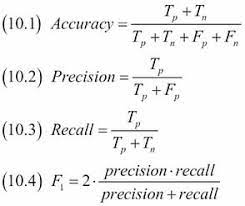

# Tiền xử lý dữ liệu
Sử dụng công cụ nltk để tiền xử lý
* Chuyển về dạng unicode
* Chuyển về dạng viết thường
* Bỏ dấu, chữ số và ký hiệu đặc biệt
* Tách từ
* Chuẩn hóa các từ viết tắt
* Loại bỏ stopwords
* Rút gọn từ
* Vector hóa từ

In [ ]:
# Từ điển chuẩn hóa từ viết tắt
contraction_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# Chuẩn bị bộ xử lý dữ liệu nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
sw = stopwords.words('english')

sw.remove('not')

lemma = WordNetLemmatizer()

In [ ]:
def normalize_text(text):
    # Chuyển về dạng unicode 
    text = unidecode(text).encode("ascii")
    text = str(text, "ascii")

    # Chuyển về dạng viết thường
    text = text.lower()
    
    # Bỏ dấu, chữ số, ký hiệu đặc biệt
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', ' ', text)  
    text = ''.join(i for i in text if not i.isdigit())
    
    # Tách từ
    tokens = word_tokenize(text)

    # Chuẩn hóa các từ viết tắt
    tokens = [contraction_dict.get(word) if (contraction_dict.get(word) != None) else word for word in tokens]

    # Loại bỏ stopwords
    tokens = [word for word in tokens if not word in sw]

    # Rút gọn từ
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    text = ' '.join(tokens)

    return text

Dữ liệu sau khi normalize

In [ ]:
train_data['normalize'] = train_data['question_text'].apply(normalize_text)
train_data

In [ ]:
X = train_data['normalize']
y = train_data['target']

# Chia train_data thành 2 tập dữ liệu train và test (tỉ lệ 4:1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Vector hóa từ**


Sử dụng CountVectorizer để trích xuất các từ, biến words thành dạng vectors trên cơ sở tần suất (số lần xuất hiện) của các từ trong bộ dữ liệu.

In [ ]:
# Khai báo hàm thực hiện
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3))

# Tiến hành tính toán trọng số của các từ trong tập huấn luyện
count_vectorizer.fit(X_train)

# Biến đổi các câu trong tập train thành ma trận trọng số của vector hóa
cv_X_train = count_vectorizer.fit_transform(X_train)
print(cv_X_train.shape)
cv_X_test = count_vectorizer.transform(X_test)
print(cv_X_test.shape)

# Mô tả mô hình được chọn
**Logistic Regression**
* Một mô hình đơn giản, phổ biến cho bài toán phân lớp có phân bố Bernoulli:
\begin{align*}
    Y|X = \mathbf x \sim Ber(y|\sigma(f(\mathbf x)))
\end{align*}
* Sử dụng đầu ra:
\begin{align*}
    f(\mathbf x) = \mathbf w^T\mathbf x + w_0
\end{align*}
* Sử dụng hàm logistic là sigmoid:
\begin{align*}
    \sigma(z) = \frac 1 {1+e^{-z}}
\end{align*}
* Huấn luyện bằng hàm lỗi:
\begin{align*}
    L(\mathbf w, w_0) &= P(D) = \prod_{i=1}^n P(y_i|\mathbf x_i) = \prod_{i=1}^n \mu_i^{y_i} (1-\mu_i)^{1-y_i}\\
    \ell(\mathbf w, w_0) &= -\log L(\mathbf w, w_0) = \sum_{i=1}^n -y_i\log\mu_i - (1-y_i)\log(1-\mu_i)\\
    \nabla_{\mathbf w} \ell(\mathbf w, w_0) &=\sum_{i=1}^n (\mu_i - y_i)\mathbf x_i\\
    \nabla_{w_0} \ell(\mathbf w, w_0) &= \sum_{i=1}^n (\mu_i - y_i)
\end{align*}
Trong đó: $\mu_i = \sigma(f(\mathbf x_i)) = \sigma(\mathbf w^T\mathbf x + w_0)$

# Thực nghiệm mô hình

In [ ]:
# Khai báo mô hình
model_LR = LogisticRegression(solver='liblinear', class_weight="balanced")

# Tiến hành huấn luyện
model_LR.fit(cv_X_train, y_train)

# Kết quả dự đoán
y_pred_LR = model_LR.predict(cv_X_test)

In [ ]:
print("Logistic Regression\n")
print('Recall: ', recall_score(y_pred_LR, y_test))
print('F1 score :', f1_score(y_pred_LR, y_test), '\n')
print(classification_report(y_test, y_pred_LR))

# Submission

In [ ]:
# normalize dữ liệu đầu vào
test_data['normalize'] = test_data['question_text'].apply(normalize_text)

# vector hóa dữ liệu
X_sub = count_vectorizer.transform(test_data['normalize'])

# Kết quả dự đoán
test_data['prediction'] = model_LR.predict(X_sub)

test_data

In [ ]:
result = test_data[['qid', 'prediction']]
result.to_csv('submission.csv', index=False)
result

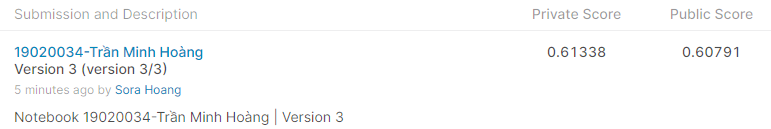